## 과정

### 전체 회귀 분석 과정
- 1.선형 회귀 모델 학습/예측/평가 및 회귀계수 시각화(릿지, 라쏘)
    - 1.1 회귀계수 시각화
    - 1.2 5폴드 교차 검증
    - 1.3 리지/라쏘 모델에 대해 alpha 하이퍼파라미터 튜닝 후 재학습/예측/평가
    - 1.4 튜닝된 모델 회귀 계수 시각화
- 2.회귀 트리 모델 학습/예측/평가 및 회귀계수 시각화(XGBoost, LGBM)
- 3.회귀 모델의 예측 결과 혼합을 통한 최종 예측
    - 3.1 릿지와 랏소 모델 예측 결과 혼합
    - 3.2 XGBoost와 LGBM 모델 예측결과 혼합
- 4.스태킹 앙상블 모델을 통한 회귀 예측

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
from matplotlib import font_manager, rc

path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

# Target 값 : price

In [2]:
car_df_ohe= pd.read_csv('./data/최종 전처리2.csv')
car_df_ohe.head()

,km,year,accident,price,wd,trim,brand_BMW,brand_기아,brand_랜드로버,brand_르노삼성,...,type_LPG,type_가솔린,type_디젤,type_바이퓨얼,type_전기,type_하이브리드,color_검정색,color_기타,color_회색,color_흰색
0,110575,11,3,6.478510,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,106819,8,3,6.846943,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
2,29151,3,3,7.544861,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,8766,1,3,8.068090,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4,101196,10,3,6.710523,0,2,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


### 1. 선형 회귀 모델 학습/예측/평가 및 회귀계수 시각화(릿지, 라쏘)

LinearRegression, Ridge, Lasso를 이용해 선형 계열의 회귀 모델 만들기

**RMSE 평가 함수 생성**

In [3]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    R2 = r2_score(y_test, pred)
    print('\n{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    print('{0} R2: {1}'.format(model.__class__.__name__,np.round(R2, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models) :
    rmses = []
    for model in models :
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [4]:
## 데이터 분할
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 타깃과 피처
y_target = car_df_ohe['price']
X_features = car_df_ohe.drop('price',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

**모델 학습/예측/평가**

In [5]:
# 일반 선형 회귀
lr_reg = LinearRegression() 
lr_reg.fit(X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

# 라쏘 회귀
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)


Lasso()

In [6]:
models= [lr_reg, ridge_reg, lasso_reg]
get_rmses(models) #학습된 모델 전달하고
# rmse값 반환


LinearRegression 로그 변환된 RMSE: 0.175
LinearRegression R2: 0.936

Ridge 로그 변환된 RMSE: 0.175
Ridge R2: 0.936

Lasso 로그 변환된 RMSE: 0.599
Lasso R2: 0.252


[0.17526710576184715, 0.17533588409711, 0.5988699977539537]

### 1.1 회귀 계수의 시각화

- 변수가 많으므로 상위10개 하위 10개의 피처명과 회귀계수값을 반환하는 함수를 작성해서 사용

In [7]:
def get_top_bottom_coef(model) :
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

In [8]:
# 모델별 회귀 계수 시각화 함수
# list 객체로 모델을 입력 받아서
# 모델별로 회귀 계수 상위 10개, 하위 10개 추출해서
# 가로 막대 그래프 형태로 출력
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

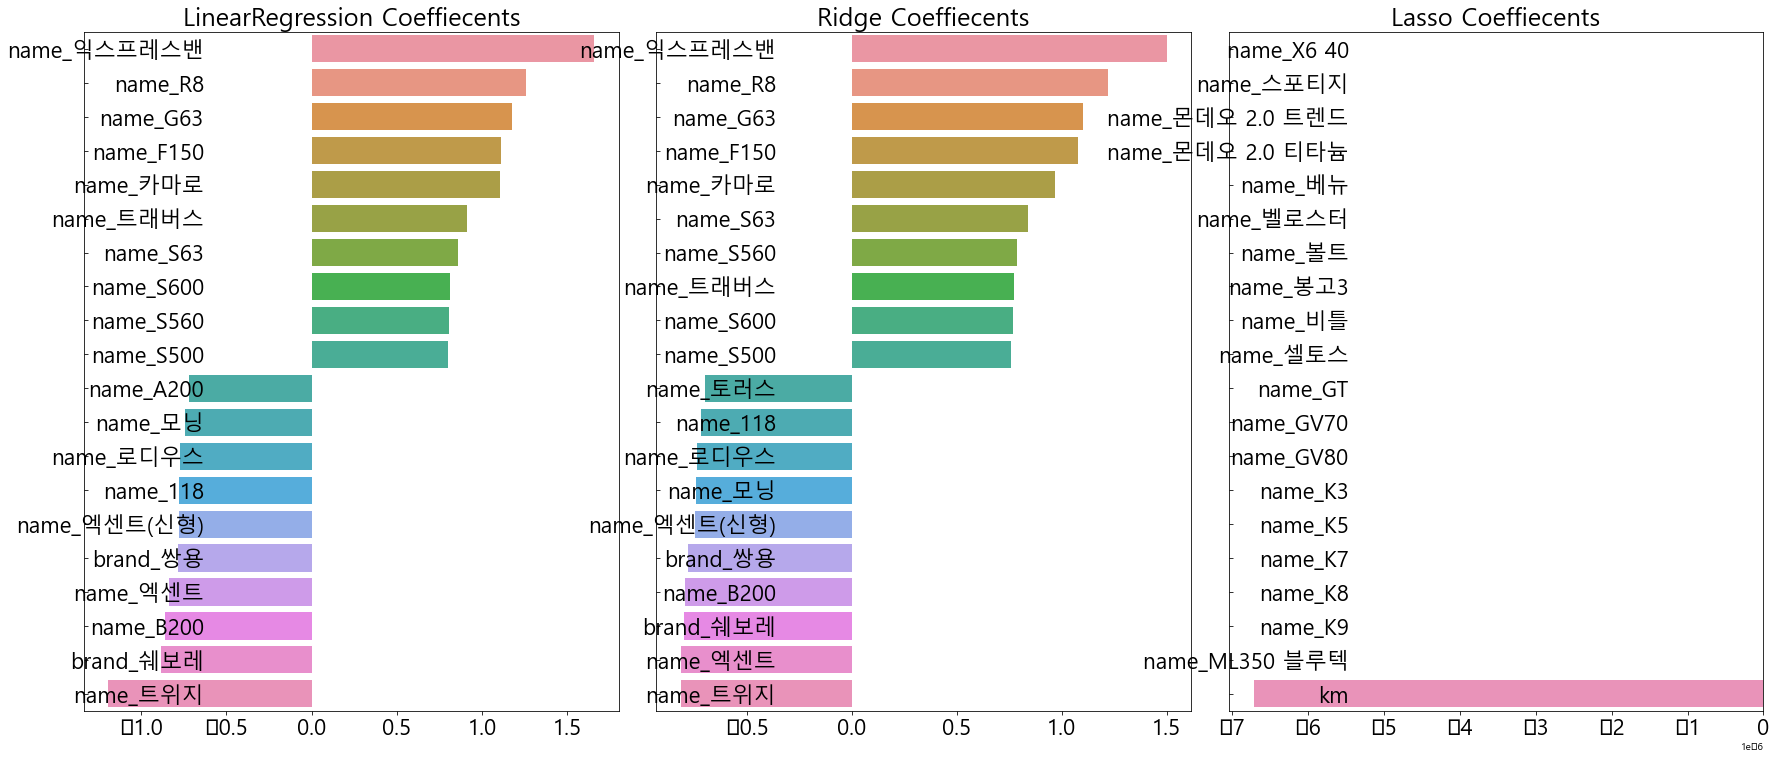

In [9]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 1.2 5폴드 교차 검증으로 평균 RMSE 측정
- 함수 생성

In [10]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models) :
    
    for model in models :
        # 분할하지 않고 전체 데이터세트로 교차검증 수행
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv=5))
        r2_list = cross_val_score(model, X_features, y_target,
                                             scoring="r2", cv=5)
        rmse_avg = np.mean(rmse_list)
        r2_avg = np.mean(r2_list)
        
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV R2 값 리스트: {1}'.format( model.__class__.__name__, np.round(r2_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))
        print('{0} CV 평균 R2 값: {1}'.format( model.__class__.__name__, np.round(r2_avg, 3)))

In [11]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.158 0.156 0.178 0.624 0.619]
LinearRegression CV R2 값 리스트: [0.938 0.938 0.92  0.31  0.28 ]
LinearRegression CV 평균 RMSE 값: 0.347
LinearRegression CV 평균 R2 값: 0.677

Ridge CV RMSE 값 리스트: [0.158 0.156 0.18  0.622 0.621]
Ridge CV R2 값 리스트: [0.938 0.938 0.918 0.313 0.276]
Ridge CV 평균 RMSE 값: 0.347
Ridge CV 평균 R2 값: 0.676

Lasso CV RMSE 값 리스트: [0.53  0.53  0.565 0.747 0.676]
Lasso CV R2 값 리스트: [0.293 0.283 0.192 0.008 0.14 ]
Lasso CV 평균 RMSE 값: 0.61
Lasso CV 평균 R2 값: 0.184


### 1.3 리지/라쏘 모델에 대해 alpha 하이퍼파라미터 튜닝 후 재학습/예측/평가

In [12]:
from sklearn.model_selection import GridSearchCV
# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서
# 최적화 작업의 결과를 표시하는 함수
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model_r2 = GridSearchCV(model, param_grid=params, 
                              scoring='r2', cv=5)
    grid_model.fit(X_features, y_target)
    grid_model_r2.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    r2 = grid_model_r2.best_score_
    print('\n{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    print('{0} 5 CV 시 최적 평균 R2 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(r2, 4), grid_model_r2.best_params_))
    return grid_model.best_estimator_ # 최적 파라미터로 재학습된 모델 반환


In [13]:
ridge_params = {'alpha' : [0.005,0.01,0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1, 1.5]}

In [14]:
best_ridge = get_best_params(ridge_reg,ridge_params)
best_lasso = get_best_params(lasso_reg,lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값: 0.4129, 최적 alpha:{'alpha': 20}
Ridge 5 CV 시 최적 평균 R2 값: 0.6769, 최적 alpha:{'alpha': 0.005}

Lasso 5 CV 시 최적 평균 RMSE 값: 0.4145, 최적 alpha:{'alpha': 0.001}
Lasso 5 CV 시 최적 평균 R2 값: 0.6714, 최적 alpha:{'alpha': 0.001}


**분할된 트레인 테스트 데이터를 이용해 학습 후 평가**

In [15]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [16]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression 로그 변환된 RMSE: 0.175
LinearRegression R2: 0.936

Ridge 로그 변환된 RMSE: 0.184
Ridge R2: 0.93

Lasso 로그 변환된 RMSE: 0.239
Lasso R2: 0.88


[0.17526710576184715, 0.18357075158874478, 0.23948057449162075]

In [17]:
#import joblib
#joblib.dump(lr_reg, open('선형 최종모델.pkl', 'wb'))

### 1.4 튜닝된 모델 회귀 계수 시각화

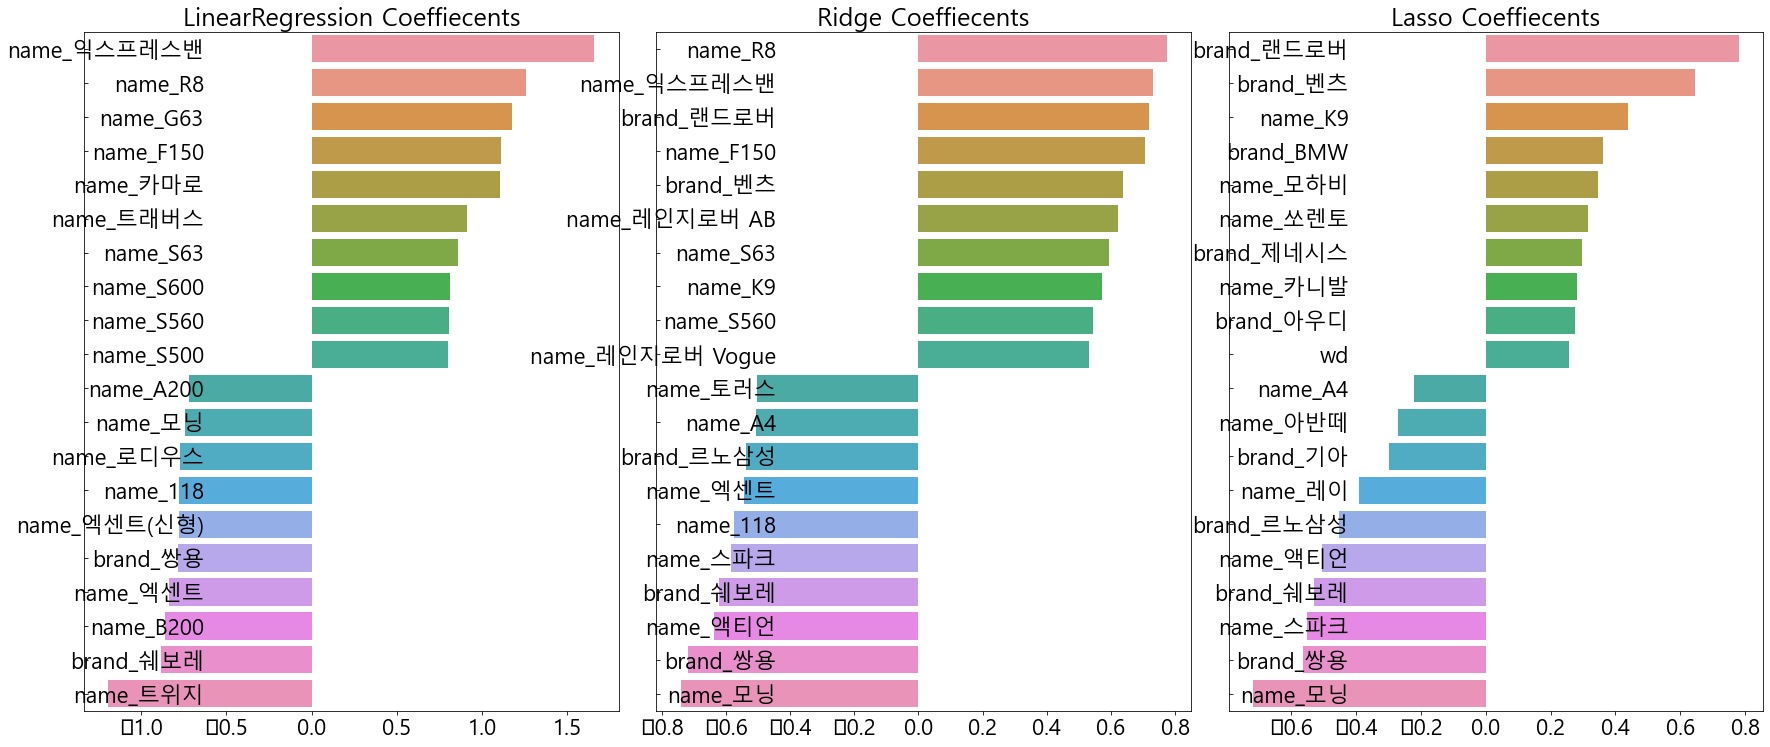

In [18]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 2. 회귀 트리 모델 학습/예측/평가 및 회귀계수 시각화(XGBoost, LGBM)


- XGBoost와 LightGBM 학습/예측/평가 

In [19]:
# XGBoost와 LightGBM 모두 수행 시간이 오래 걸릴 수 있는 관계로
# 하이퍼 파라미터 설정을 미리 적용한 상태로
# 5 폴드 세트에 대한 평균 RMSE 값 추출

from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}

xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                      colsample_bytree=0.5, subsample=0.8)

best_xgb = get_best_params(xgb_reg, xgb_params)


XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.3904, 최적 alpha:{'n_estimators': 1000}
XGBRegressor 5 CV 시 최적 평균 R2 값: 0.7159, 최적 alpha:{'n_estimators': 1000}


In [20]:
# 이번에는 LightGBM 회귀 트리 적용

from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)


LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.4047, 최적 alpha:{'n_estimators': 1000}
LGBMRegressor 5 CV 시 최적 평균 R2 값: 0.6896, 최적 alpha:{'n_estimators': 1000}


**트리 회귀 모델의 피처 중요도 시각화**

In [21]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

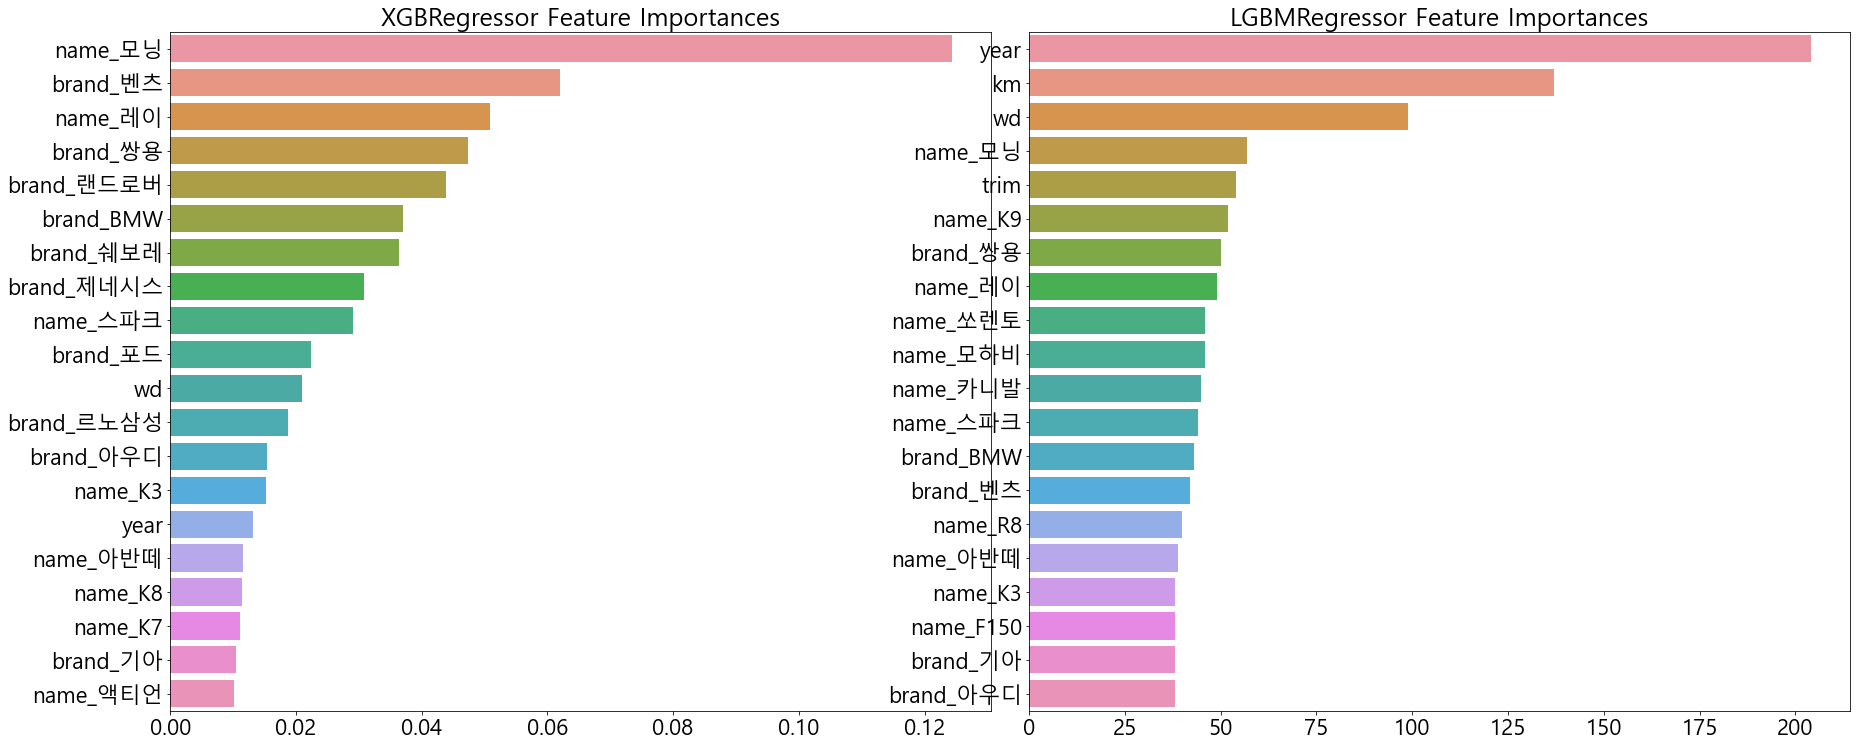

In [22]:
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

### 3.회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [23]:
# 최종 혼합 모델과 개별 모델의 RMSE 값 출력하는 함수 생성
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        R2 = r2_score(y_test, pred_value)
        print('\n{0} 모델의 RMSE: {1}'.format(key, np.round(rmse, 3)))
        print('{0} 모델의 R2: {1}'.format(key, np.round(R2, 3)))

In [24]:
# 개별 모델 학습
ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

#### 3.1 릿지와 랏소 모델 예측 결과 혼합

In [25]:
# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.6 * ridge_pred + 0.4*lasso_pred

In [26]:
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.199
최종 혼합 모델의 R2: 0.917

Ridge 모델의 RMSE: 0.184
Ridge 모델의 R2: 0.93

Lasso 모델의 RMSE: 0.239
Lasso 모델의 R2: 0.88


#### 3.2 XGBoost와 LGBM 모델 예측결과 혼합 (각 50%)

In [27]:
# model save
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)



In [28]:
xgb_pred

array([7.3385887, 7.1259236, 7.4634748, ..., 6.5214343, 7.7996707,
       7.788943 ], dtype=float32)

In [29]:
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.151
최종 혼합 모델의 R2: 0.952

XGBM 모델의 RMSE: 0.13
XGBM 모델의 R2: 0.965

LGBM 모델의 RMSE: 0.185
LGBM 모델의 R2: 0.928


### 4.스태킹 앙상블 모델을 통한 회귀 예측

In [30]:
from sklearn.model_selection import KFold #트레인데이터를 학습/검증 세트로 분리하기 위해 필요
from sklearn.metrics import mean_absolute_error

In [31]:
# 개별 기반 모델(1개의 모델) 최종 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n,y_train_n,X_test_n,n_folds) :
    # 지정된 n_folds 값으로 KFold 객체 생성
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=0)
    
    # 최종모델이 사용할 학습 데이터를 위한 초기 구성 - 넘파이배열로 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
       #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 테스트 데이터를 폴드세트의 평균으로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, 
    # test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean    
    
    

**기반 개별 모델은 리지, 라소, XGBoost, LightGBM 으로 생성**
- 최종 모델을 라소로 생성하여 학습/예측/평가

In [32]:
# 생성한 함수가 ndarray를 인자로 사용하므로 DF를 ndarray로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

In [33]:
# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [34]:
# 각 개별 모델이 반환한 학습용피처 데이터와 테스트용피터 데이터 세트를 결합해서 최종데이터세트 생성
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

In [35]:
Stack_final_X_train

array([[7.67667356, 7.7281906 , 7.70803261, 7.75438735],
       [7.87703529, 7.86356327, 7.87833548, 7.86149301],
       [7.87830315, 7.86490264, 7.80200243, 7.88294919],
       ...,
       [7.51911219, 7.48534161, 7.44629526, 7.47002203],
       [8.0972205 , 8.05082245, 8.12671566, 8.0163081 ],
       [7.60566724, 7.61438563, 7.61449432, 7.6250003 ]])

In [36]:
# 최종 모델을 릿지 모델을 적용
meta_model_ridge = Ridge(alpha=20)

In [37]:
meta_model_ridge.fit(Stack_final_X_train,y_train)
final = meta_model_ridge.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse=np.sqrt(mse)
R2 = r2_score(y_test, final)

print('릿지 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은:', np.round(rmse, 3))
print('릿지 모델 적용 스태킹 회귀 모델의 최종 R2 값은:', np.round(R2, 3))

릿지 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.126
릿지 모델 적용 스태킹 회귀 모델의 최종 R2 값은: 0.967


In [38]:
# 최종 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.001)

In [39]:
meta_model_lasso.fit(Stack_final_X_train,y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse=np.sqrt(mse)
R2 = r2_score(y_test, final)

print('라쏘 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은:', np.round(rmse, 3))
print('라쏘 모델 적용 스태킹 회귀 모델의 최종 R2 값은:', np.round(R2, 3))

라쏘 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.127
라쏘 모델 적용 스태킹 회귀 모델의 최종 R2 값은: 0.966


In [40]:
# 최종 모델은 XGBoost, LightGBM 모델을 적용
meta_model_xgb_reg = xgb_reg

In [41]:
# model save
meta_model_xgb_reg.fit(Stack_final_X_train,y_train)
final = meta_model_xgb_reg.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse=np.sqrt(mse)
R2 = r2_score(y_test, final)

print('XGBoost 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은:', np.round(rmse, 3))
print('XGBoost 모델 적용 스태킹 회귀 모델의 최종 R2 값은:', np.round(R2, 3))

XGBoost 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.125
XGBoost 모델 적용 스태킹 회귀 모델의 최종 R2 값은: 0.968


In [42]:
# 최종 모델은 LightGBM 모델을 적용
meta_model_lgbm_reg = lgbm_reg

In [43]:
meta_model_lgbm_reg.fit(Stack_final_X_train,y_train)
final = meta_model_lgbm_reg.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse=np.sqrt(mse)
R2 = r2_score(y_test, final)

print('LightGBM 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은:', np.round(rmse, 3))
print('LightGBM 모델 적용 스태킹 회귀 모델의 최종 R2 값은:', np.round(R2, 3))

LightGBM 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.135
LightGBM 모델 적용 스태킹 회귀 모델의 최종 R2 값은: 0.962


In [44]:

test=X_features.head()
test

,km,year,accident,wd,trim,brand_BMW,brand_기아,brand_랜드로버,brand_르노삼성,brand_미니,...,type_LPG,type_가솔린,type_디젤,type_바이퓨얼,type_전기,type_하이브리드,color_검정색,color_기타,color_회색,color_흰색
0,110575,11,3,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,106819,8,3,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,29151,3,3,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,8766,1,3,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,101196,10,3,0,2,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [45]:
np.expm1(y_target).head()

0     650.0
1     940.0
2    1890.0
3    3190.0
4     820.0
Name: price, dtype: float64

### 아무것도 처리 안한것:

- LinearRegression 로그 변환된 RMSE: 0.173
- LinearRegression R2: 0.938

- Ridge 로그 변환된 RMSE: 0.173
- Ridge R2: 0.938

- Lasso 로그 변환된 RMSE: 0.6
- Lasso R2: 0.246

### 5폴드 교차검증한것:

- Ridge 5 CV 시 최적 평균 RMSE 값: 0.4056
- Ridge 5 CV 시 최적 평균 R2 값: 0.7056

- Lasso 5 CV 시 최적 평균 RMSE 값: 0.4085
- Lasso 5 CV 시 최적 평균 R2 값: 0.6957

- XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.3801
- XGBRegressor 5 CV 시 최적 평균 R2 값: 0.7458

- LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.3938
- LGBMRegressor 5 CV 시 최적 평균 R2 값: 0.7204

### 최적의 하이퍼파라미터 적용한것

- LinearRegression 로그 변환된 RMSE: 0.173
- LinearRegression R2: 0.938

- Ridge 로그 변환된 RMSE: 0.182
- Ridge R2: 0.931

- Lasso 로그 변환된 RMSE: 0.239
- Lasso R2: 0.88

- XGBM 모델의 RMSE: 0.131
- XGBM 모델의 R2: 0.964

- LGBM 모델의 RMSE: 0.188
- LGBM 모델의 R2: 0.926

### 혼합한것

- 릿지 60%, 라쏘 40% 최종 혼합 모델의 RMSE: 0.198
- 릿지 60%, 라쏘 40% 최종 혼합 모델의 R2: 0.918

- XGBM 50%, LGBM 50% 혼합 모델의 RMSE: 0.153
- XGBM 50%, LGBM 50% 혼합 모델의 R2: 0.951

### 스태킹 모델 적용한것

- 릿지 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.126
- 릿지 모델 적용 스태킹 회귀 모델의 최종 R2 값은: 0.967

- 라쏘 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.128
- 라쏘 모델 적용 스태킹 회귀 모델의 최종 R2 값은: 0.966

- XGBoost 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.124
- XGBoost 모델 적용 스태킹 회귀 모델의 최종 R2 값은: 0.968

- LightGBM 모델 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.136
- LightGBM 모델 적용 스태킹 회귀 모델의 최종 R2 값은: 0.961

In [46]:
# 사용자 입력 데이터 
new_data = {'km':300000,'year':2018,'wd':0,'brand':'기아','trim':2}


In [47]:
def make_dataset(inputdata) :
    return make_df